[Reference](https://towardsdatascience.com/bayesian-a-b-testing-with-continuous-variables-including-python-code-133b74c7bd20)

In [1]:
import pandas as pd
import requests
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import theano.tensor as tt
from scipy.stats.mstats import mquantiles

In [2]:
rng = np.random.default_rng()

df_control = pd.DataFrame(rng.integers(1, 100, size=(500, 1)), columns=['pvs_pb'])

df_control['variant'] = 'control'

df_variant = pd.DataFrame(rng.integers(60, 120, size=(500, 1)), columns=['pvs_pb'])

df_variant['variant'] = 'variant'

df = df_control.append(df_variant)

In [3]:
df.groupby(['variant']).count()

,pvs_pb
variant,
control,500
variant,500


In [5]:
df.groupby(['variant']).mean()

,pvs_pb
variant,
control,51.698
variant,90.398


In [6]:
control = df[(df['variant'] == 'control')]
variant = df[(df['variant'] == 'variant')]

In [7]:
pooled_mean = np.r_[control.pvs_pb, variant.pvs_pb].mean()
pooled_std = np.r_[control.pvs_pb, variant.pvs_pb].std()
variance = 2 * pooled_std
with pm.Model() as model_1:
    mu_A = pm.Normal("mu_A", pooled_mean, sd = variance)
    mu_B = pm.Normal("mu_B", pooled_mean, sd = variance)
    std_A = pm.Uniform("std_A", 1/100, 100)
    std_B = pm.Uniform("std_B", 1/100, 100)
    nu_minus_1 = pm.Exponential("nu-1", 1.0/29)

In [8]:
with model_1:
    obs_A = pm.StudentT("obs_A", mu = mu_A, lam = 1.0/std_A**2, nu = nu_minus_1+1, observed=control.pvs_pb)
    obs_B = pm.StudentT("obs_B", mu = mu_B, lam = 1.0/std_B**2, nu=nu_minus_1+1, observed=variant.pvs_pb)
    start = pm.find_MAP()
    step = pm.Metropolis(vars =[mu_A, mu_B, std_A, std_B, nu_minus_1])
    trace_1 = pm.sample(25000, step = step)
    burned_trace_1 = trace_1[10000:]

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -4,555.9, ||grad|| = 0.16657: 100%|██████████| 33/33 [00:00<00:00, 750.41it/s]  
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [nu-1]
>Metropolis: [std_B]
>Metropolis: [std_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]
100%|██████████| 25500/25500 [00:28<00:00, 895.71it/s]
The number of effective samples is smaller than 10% for some parameters.


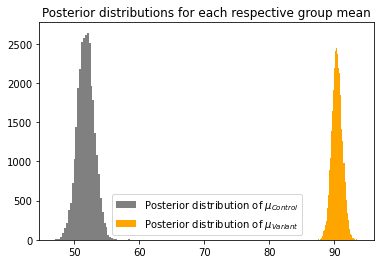

In [10]:
control_mean = burned_trace_1['mu_A']
variant_mean = burned_trace_1['mu_B']
plt.hist(control_mean, bins = 40, label=r'Posterior distribution of $\mu_{Control}$', color = 'grey')
plt.hist(variant_mean, bins = 40, label=r'Posterior distribution of $\mu_{Variant}$', color = 'orange')
plt.title('Posterior distributions for each respective group mean')
plt.legend()
plt.show()

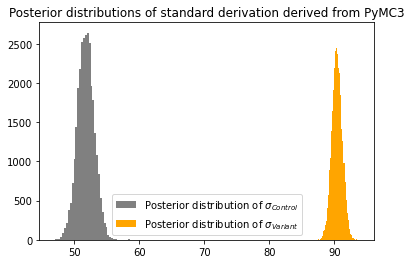

In [15]:
control_std = burned_trace_1['mu_A']
variant_std = burned_trace_1['mu_B']
plt.hist(control_std, bins = 40, label=r'Posterior distribution of $\sigma_{Control}$', color = 'grey')
plt.hist(variant_std, bins = 40, label=r'Posterior distribution of $\sigma_{Variant}$', color = 'orange')
plt.title('Posterior distributions of standard derivation derived from PyMC3')
plt.legend()
plt.show()

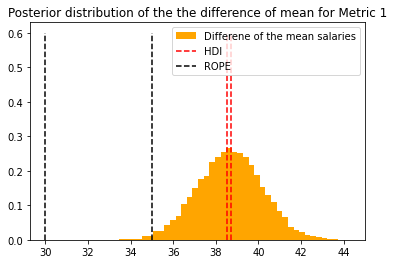

In [17]:
difference = variant_mean - control_mean # Difference of the means

hdi = pm.stats.hpd(difference, 0.95) # The 95% HDI interval of the difference

rope = [30,35] #the ROPE region

plt.hist(difference, bins=50, density=True, label='Differene of the mean salaries', color = 'orange')
plt.title('Posterior distribution of the the difference of the means')
plt.vlines(hdi[0], 0,0.6, linestyle='--', color='red', label='HDI')
plt.vlines(hdi[1], 0, 0.6, linestyle='--', color='red')
plt.vlines(rope[0], 0, 0.6, linestyle='--', color='black', label='ROPE')
plt.vlines(rope[1], 0, 0.6, linestyle='--', color='black')
plt.title('Posterior distribution of the the difference of mean for Metric 1')
plt.legend(loc='upper right')
plt.show()

The probability that the variant performed 40% greater than the control is: 96.29%


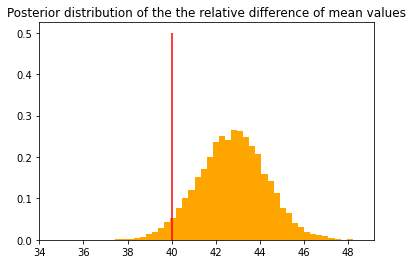

In [18]:
rel_difference = 100 * (variant_mean-control_mean)/variant_mean
prob = len(rel_difference[rel_difference > 40])/len(rel_difference)
plt.hist(rel_difference, bins=50, density=True, label='Relative differene of the mean metric', color = 'orange')
plt.title('Posterior distribution of the the relative difference of mean values')
plt.vlines(40, 0,0.5, linestyle='-', color='red', label='HDI')
print(f"The probability that the variant performed 40% greater than the control is: {round(prob*100,2)}%")
plt.show()

The probability that the variant performed 40% greater than the control is: 96.29%


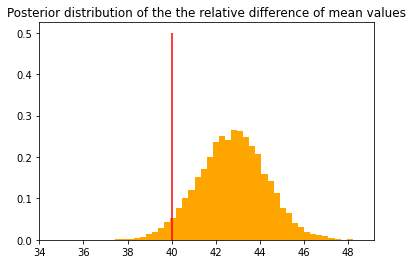

In [20]:
rel_difference = 100 * (variant_mean-control_mean)/variant_mean
prob = len(rel_difference[rel_difference > 40])/len(rel_difference)
plt.hist(rel_difference, bins=50, density=True, label='Relative differene of the mean metric', color = 'orange')
plt.title('Posterior distribution of the the relative difference of mean values')
plt.vlines(40, 0,0.5, linestyle='-', color='red', label='HDI')
print(f"The probability that the variant performed 40% greater than the control is: {round(prob*100,2)}%")
plt.show()